# Analyzing Neural Time Series Data: Chapter 12

### Morlet Wavelets and Wavelet Convolution

Converted from MATLAB to Python by Andrew J. Graves on 02/19/20

In [1]:
# Get matplotlib magic
%matplotlib notebook 

# Import modules
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

# Run data extraction and useful function script; double quotes work for Windows and Mac paths
%run "data_and_funcs.ipynb"

# AJG functions
# help(gauss_win)

### Figure 12.1

**Gaussian windows**

Let $a$ be amplitude, $t$ time, $f$ frequency, $n$ the number of wavelet cycles, $s$ standard deviation of the Gaussian

$$s = \frac{n}{2 \pi f}$$

- Assuming the x-axis offset is 0, Gaussian windows for Morlet wavelets can be generated through the following equation:

$$ae^{-(t^2) / (2s^2)}$$

<IPython.core.display.Javascript object>


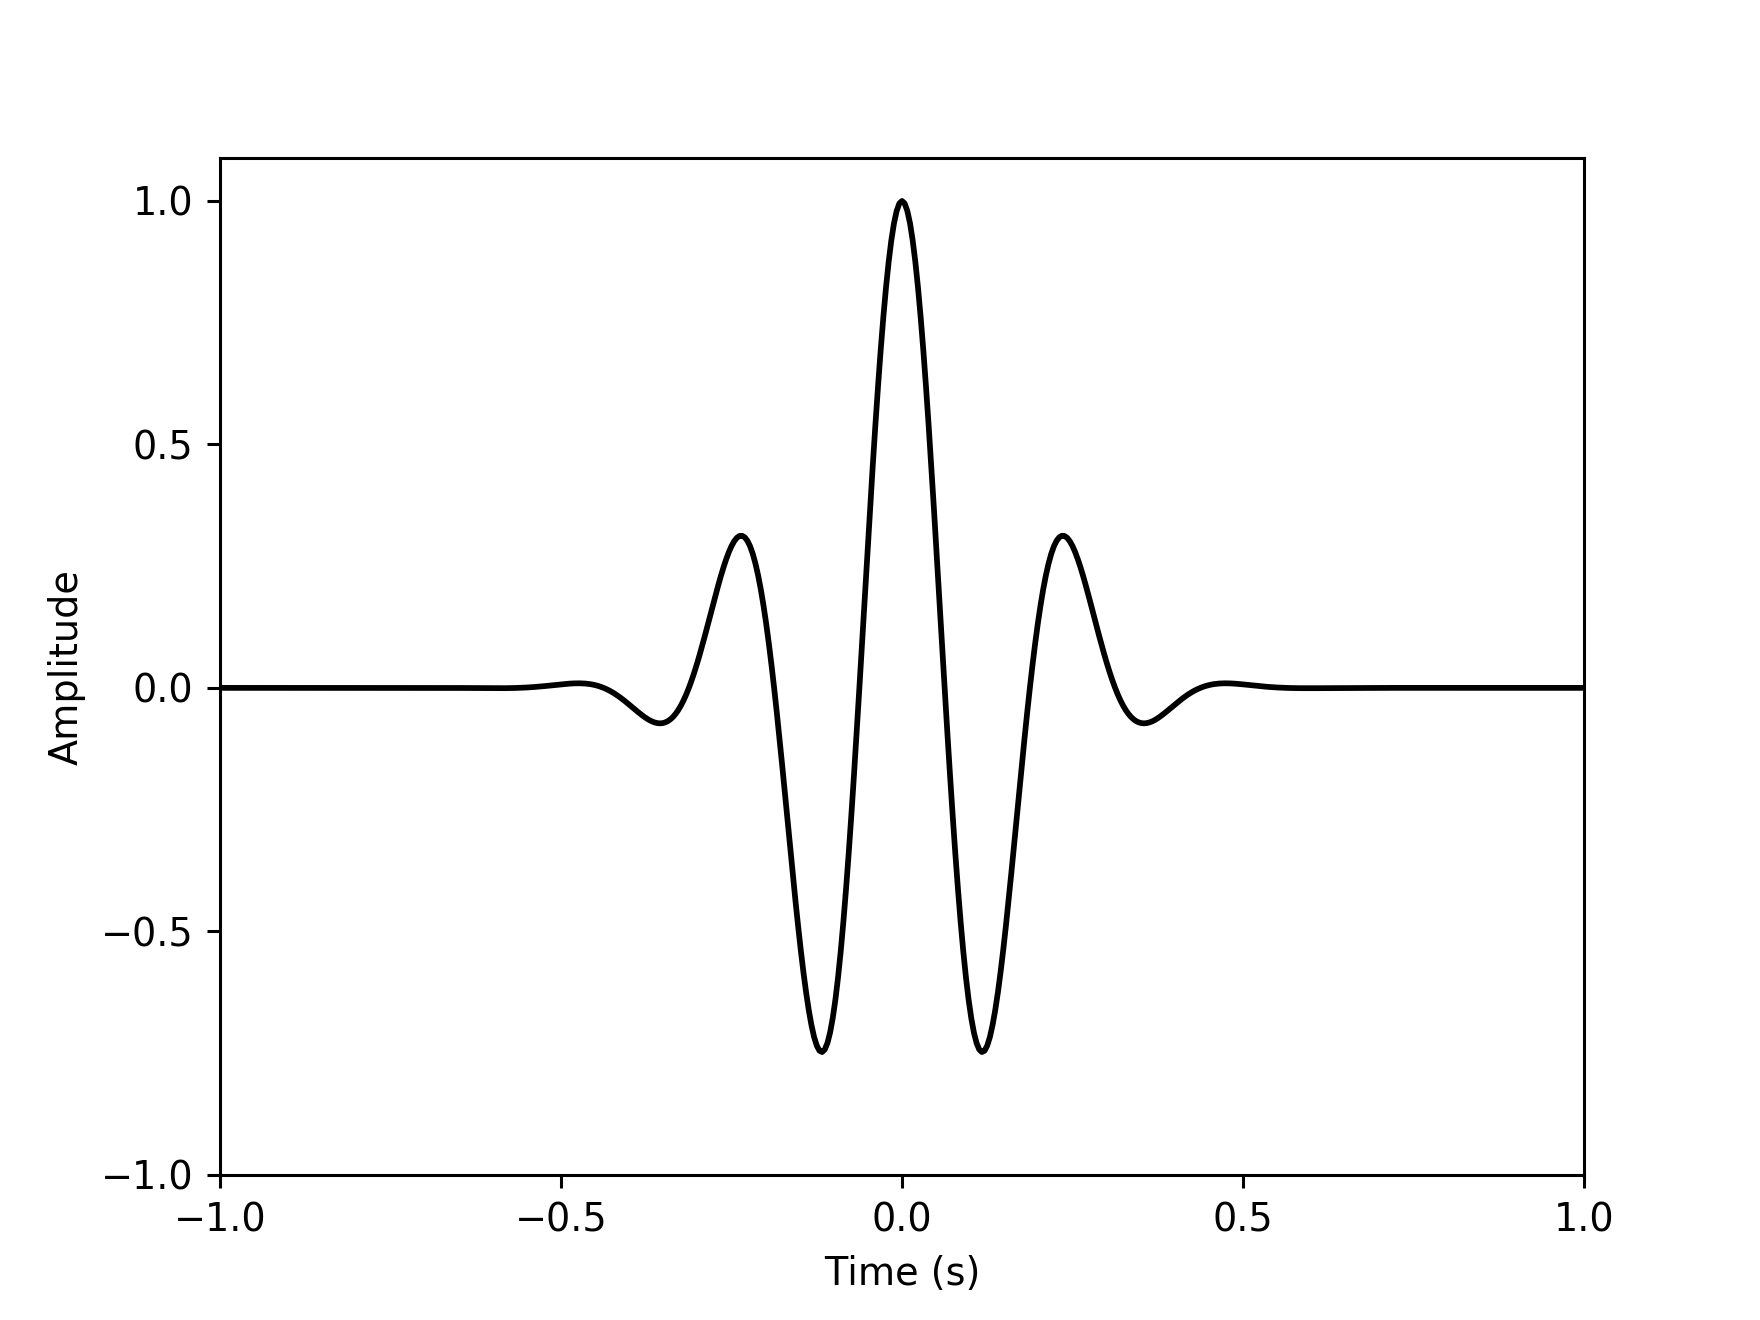

In [2]:
samp_rate = int(samp_rate)
freq = 4
n_cycles = 4
eeg_time = time_series(samp_rate)

# Cosine wave instead of sine wave (for reasons detailed in Chapter 13)
cos_wave = get_sine_wave(freq, samp_rate, cos=True)

# Gaussian window
gaussian_window = gauss_win(freq, samp_rate, n_cycles)

# Morlet Wavelet, created by windowing a waveform by a Gaussian
plt.figure()
plt.plot(eeg_time, cos_wave * gaussian_window, color='black')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim([-1, 1])
plt.xticks(np.linspace(-1, 1, 5))
plt.yticks(np.linspace(-1, 1, 5))
plt.show()

### Figure 12.2

<IPython.core.display.Javascript object>


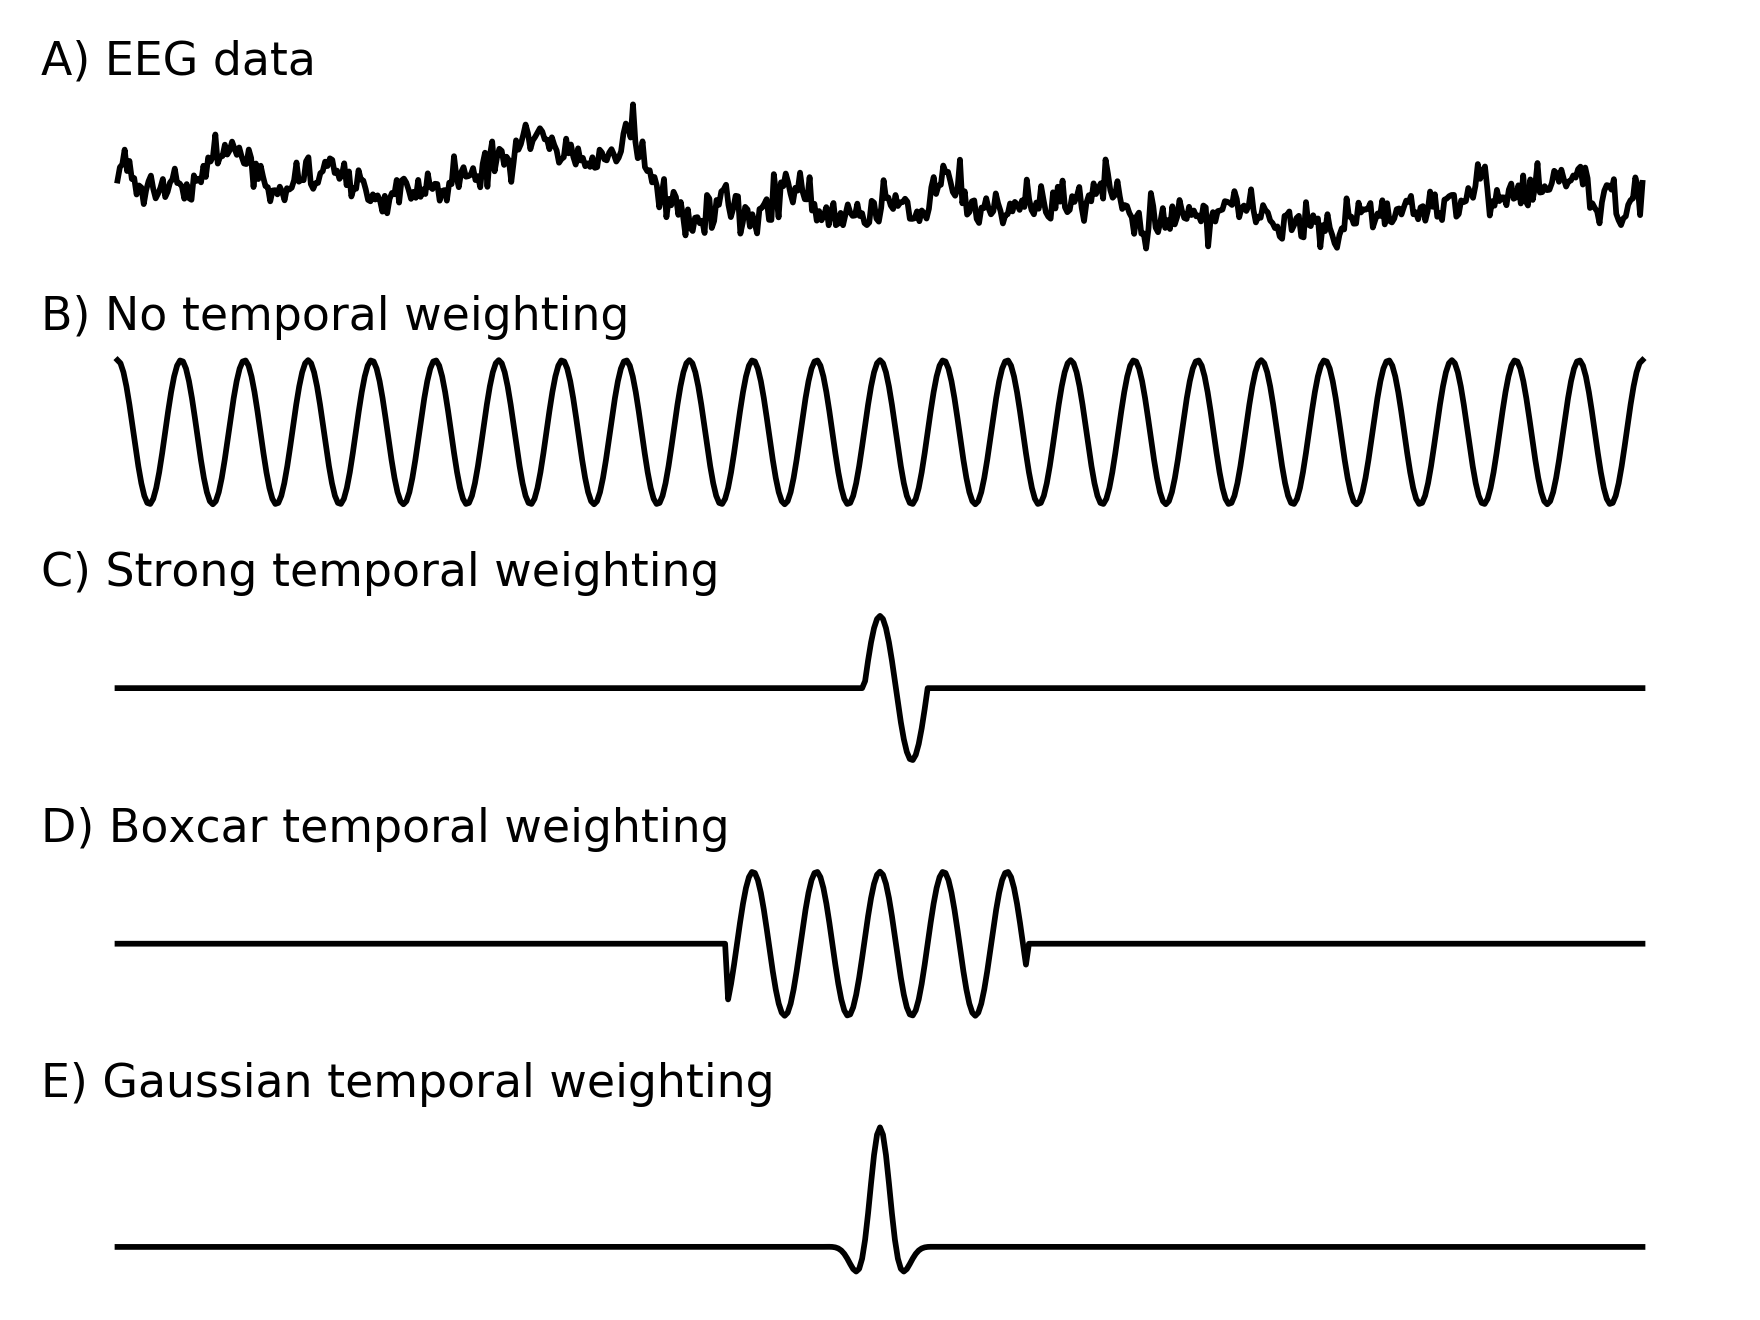

In [3]:
freq = 12
n_cycles = 1.5

fig, ax = plt.subplots(nrows=5)

for i in ax:
    i.axis('off')

# EEG data
ax[0].plot(np.squeeze(eeg_data[46, :, 0]), color='black')
ax[0].set_title('A) EEG data', loc='left')

# No weighting, as implemented in the Fourier transform
cos_wave = get_sine_wave(freq, samp_rate, cos=True)
ax[1].plot(cos_wave, color='black')
ax[1].set_title('B) No temporal weighting', loc='left')

# Narrow boxcar
boxcar = np.zeros(len(cos_wave))
midpoint_idx = int((len(boxcar) - 3) / 2)
boxcar[midpoint_idx - round(samp_rate / freq / 5):midpoint_idx + round(samp_rate / freq / 1.25) + 1] = 1
ax[2].plot(cos_wave * boxcar, color='black')
ax[2].set_title('C) Strong temporal weighting', loc='left')

# Wide boxcar
boxcar = np.zeros(len(cos_wave))
boxcar[midpoint_idx - 50:midpoint_idx + 51] = 1
ax[3].plot(cos_wave * boxcar, color='black')
ax[3].set_title('D) Boxcar temporal weighting', loc='left')

# Morlet Wavelet
gaussian_window = gauss_win(freq, samp_rate, n_cycles)
ax[4].plot(cos_wave * gaussian_window, color='black')
ax[4].set_title('E) Gaussian temporal weighting', loc='left')
    
fig.tight_layout()

### Figure 12.3

<IPython.core.display.Javascript object>


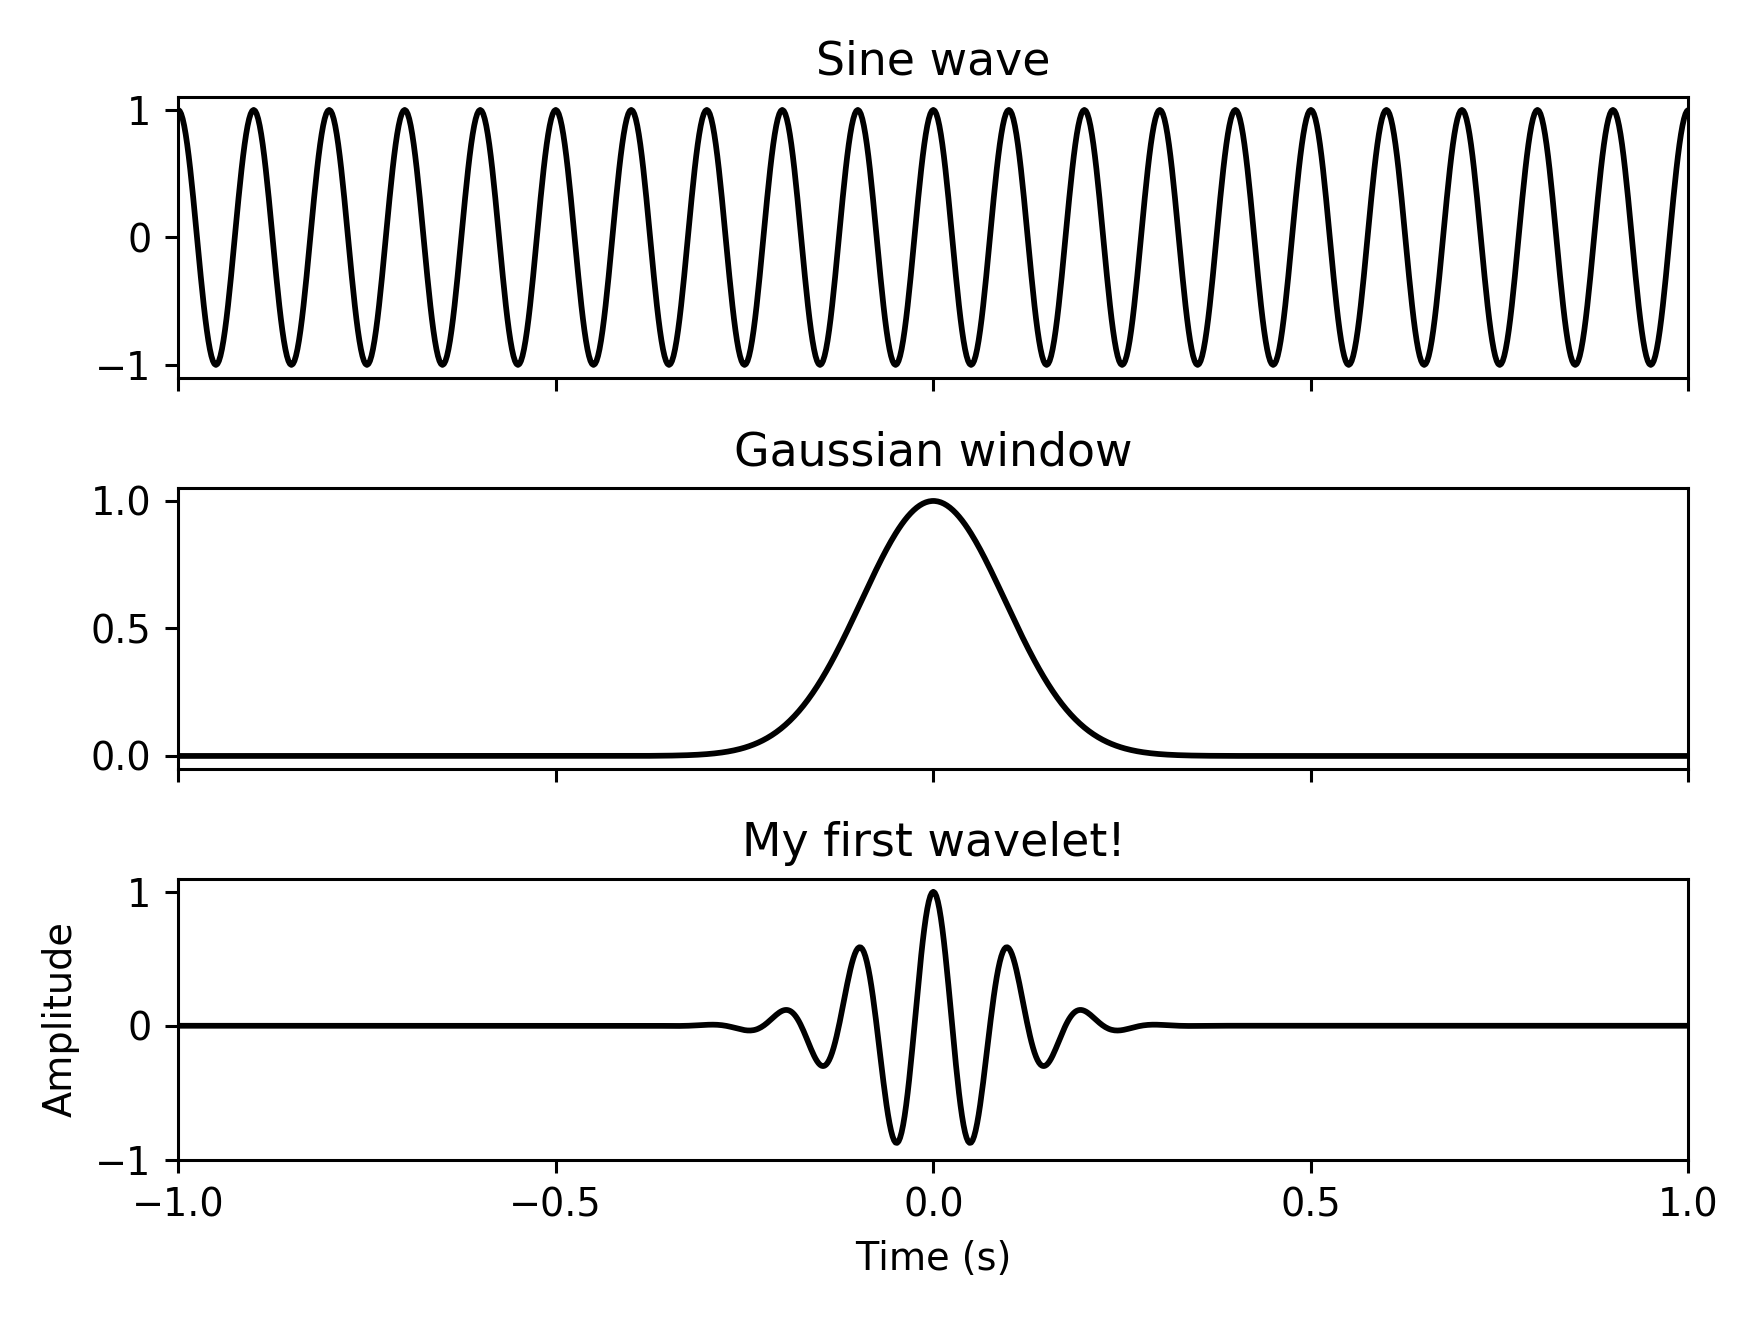

In [4]:
srate = 500
freq = 10
n_cycles = 6
time = time_series(srate)

# Complex sine wave
complex_sine = get_sine_wave(freq, srate, complex_wave=True)
gaussian_window = gauss_win(freq, srate, n_cycles)
wavelet = complex_sine * gaussian_window

fig, ax = plt.subplots(nrows=3, sharex=True)

for i in ax:
    i.set_xlim([-1, 1])

ax[0].plot(time, np.real(complex_sine), color='black')
ax[0].set_title('Sine wave')

ax[1].plot(time, gaussian_window, color='black')
ax[1].set_title('Gaussian window')

ax[2].plot(time, np.real(wavelet), color='black')
ax[2].set_title('My first wavelet!')
ax[2].set_xlabel('Time (s)')
ax[2].set_xticks(np.linspace(-1, 1, 5))
ax[2].set_ylabel('Amplitude')
ax[2].set_yticks(np.linspace(-1, 1, 3))

fig.tight_layout()

### Figure 12.4

<IPython.core.display.Javascript object>


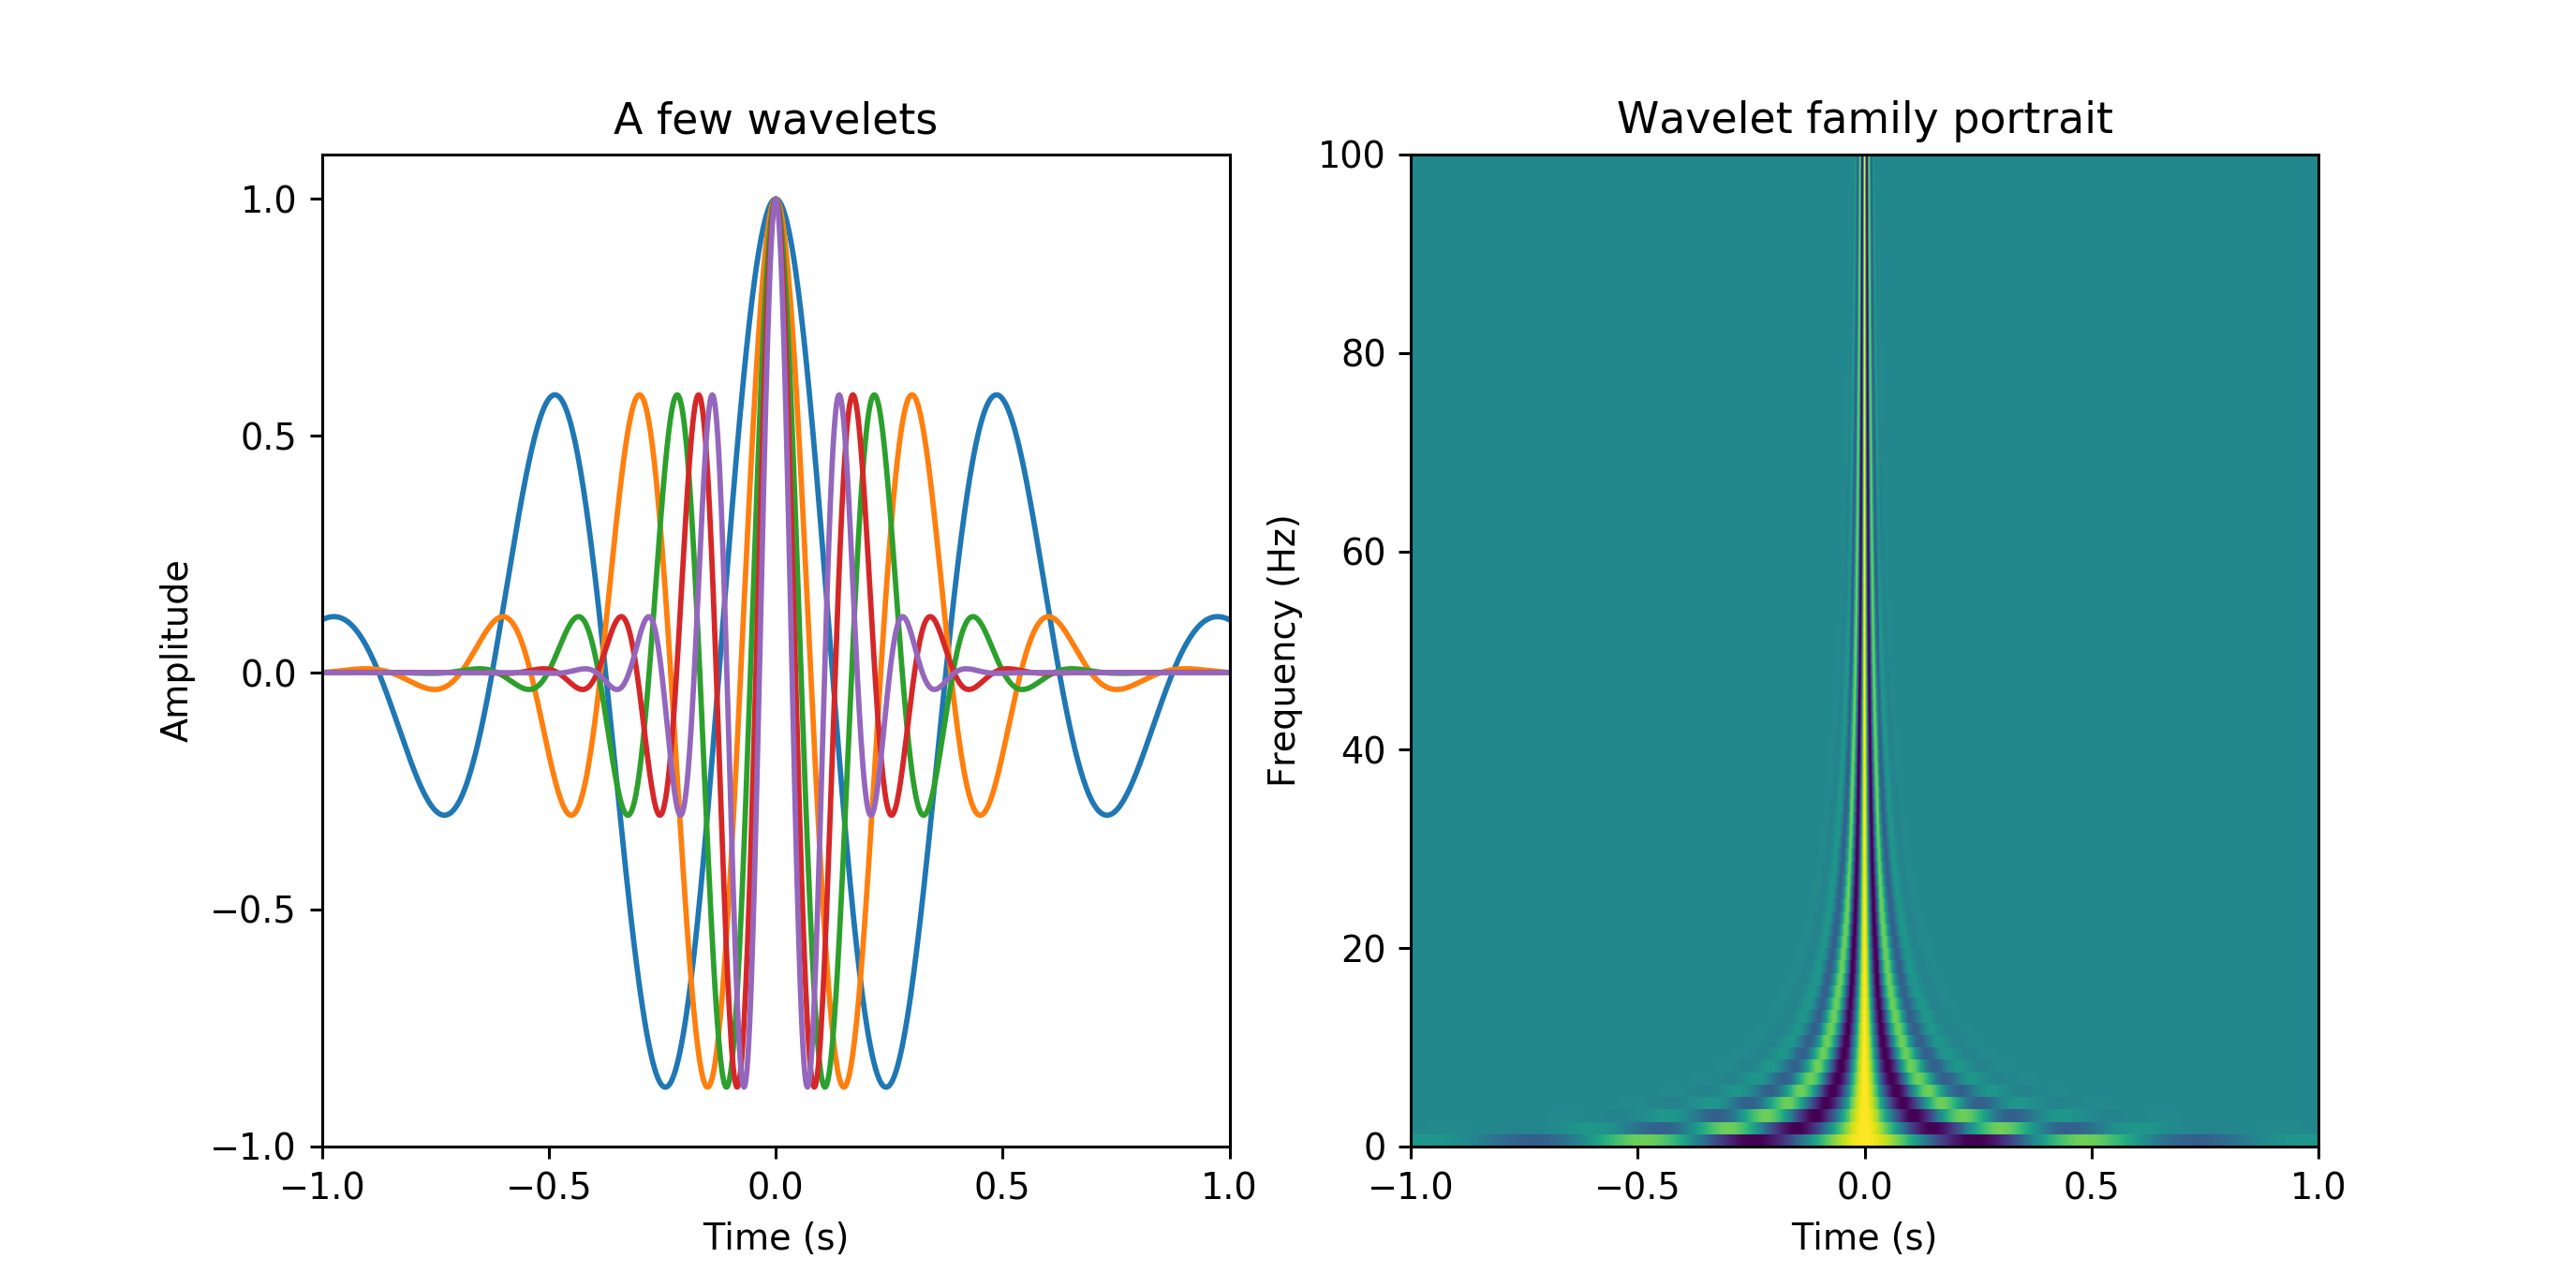

In [5]:
num_wavelets = 80 # Number of frequency bands
lowest_freq = 2 # Hz
highest_freq = 100 # Hz

# Linearly spaced frequencies
frequencies = np.linspace(lowest_freq, highest_freq, num_wavelets)

# Initialize wavelet family
wavelet_family = np.zeros((num_wavelets, len(time)), dtype=complex)

# Iterate through frequencies to make a family of wavelets
for i in range(num_wavelets):
    
    # Create the sine wave
    sine_wave = get_sine_wave(frequency=frequencies[i], srate=srate, complex_wave=True)
    
    # Create the Gaussian window
    gaussian_window = gauss_win(frequency=frequencies[i], srate=srate, num_cycle=6)
    
    # Add to the wavelet family array
    wavelet_family[i, :] = sine_wave * gaussian_window
    
widths = [1.3, 1]
    
fig, ax = plt.subplots(ncols=2, figsize = (10, 5))
#gridspec_kw = {'width_ratios': widths})

for i in ax:
    i.set_xticks(np.linspace(-1, 1, 5))

for i in range(5):
    # Can't replicate Cohen's directly because of random number generation; plotting first 5 wavelets instead...
    ax[0].plot(time, np.real(wavelet_family[i, :]))
    ax[0].set_yticks(np.linspace(-1, 1, 5))
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Amplitude')
    ax[0].set_title('A few wavelets')
    ax[0].set_xlim([-1, 1])
    
    ax[1].imshow(np.real(wavelet_family), aspect='auto', extent=[-1, 1, 100, 0])
    ax[1].invert_yaxis()
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Frequency (Hz)')
    ax[1].set_title('Wavelet family portrait')

### Figure 12.5

<IPython.core.display.Javascript object>


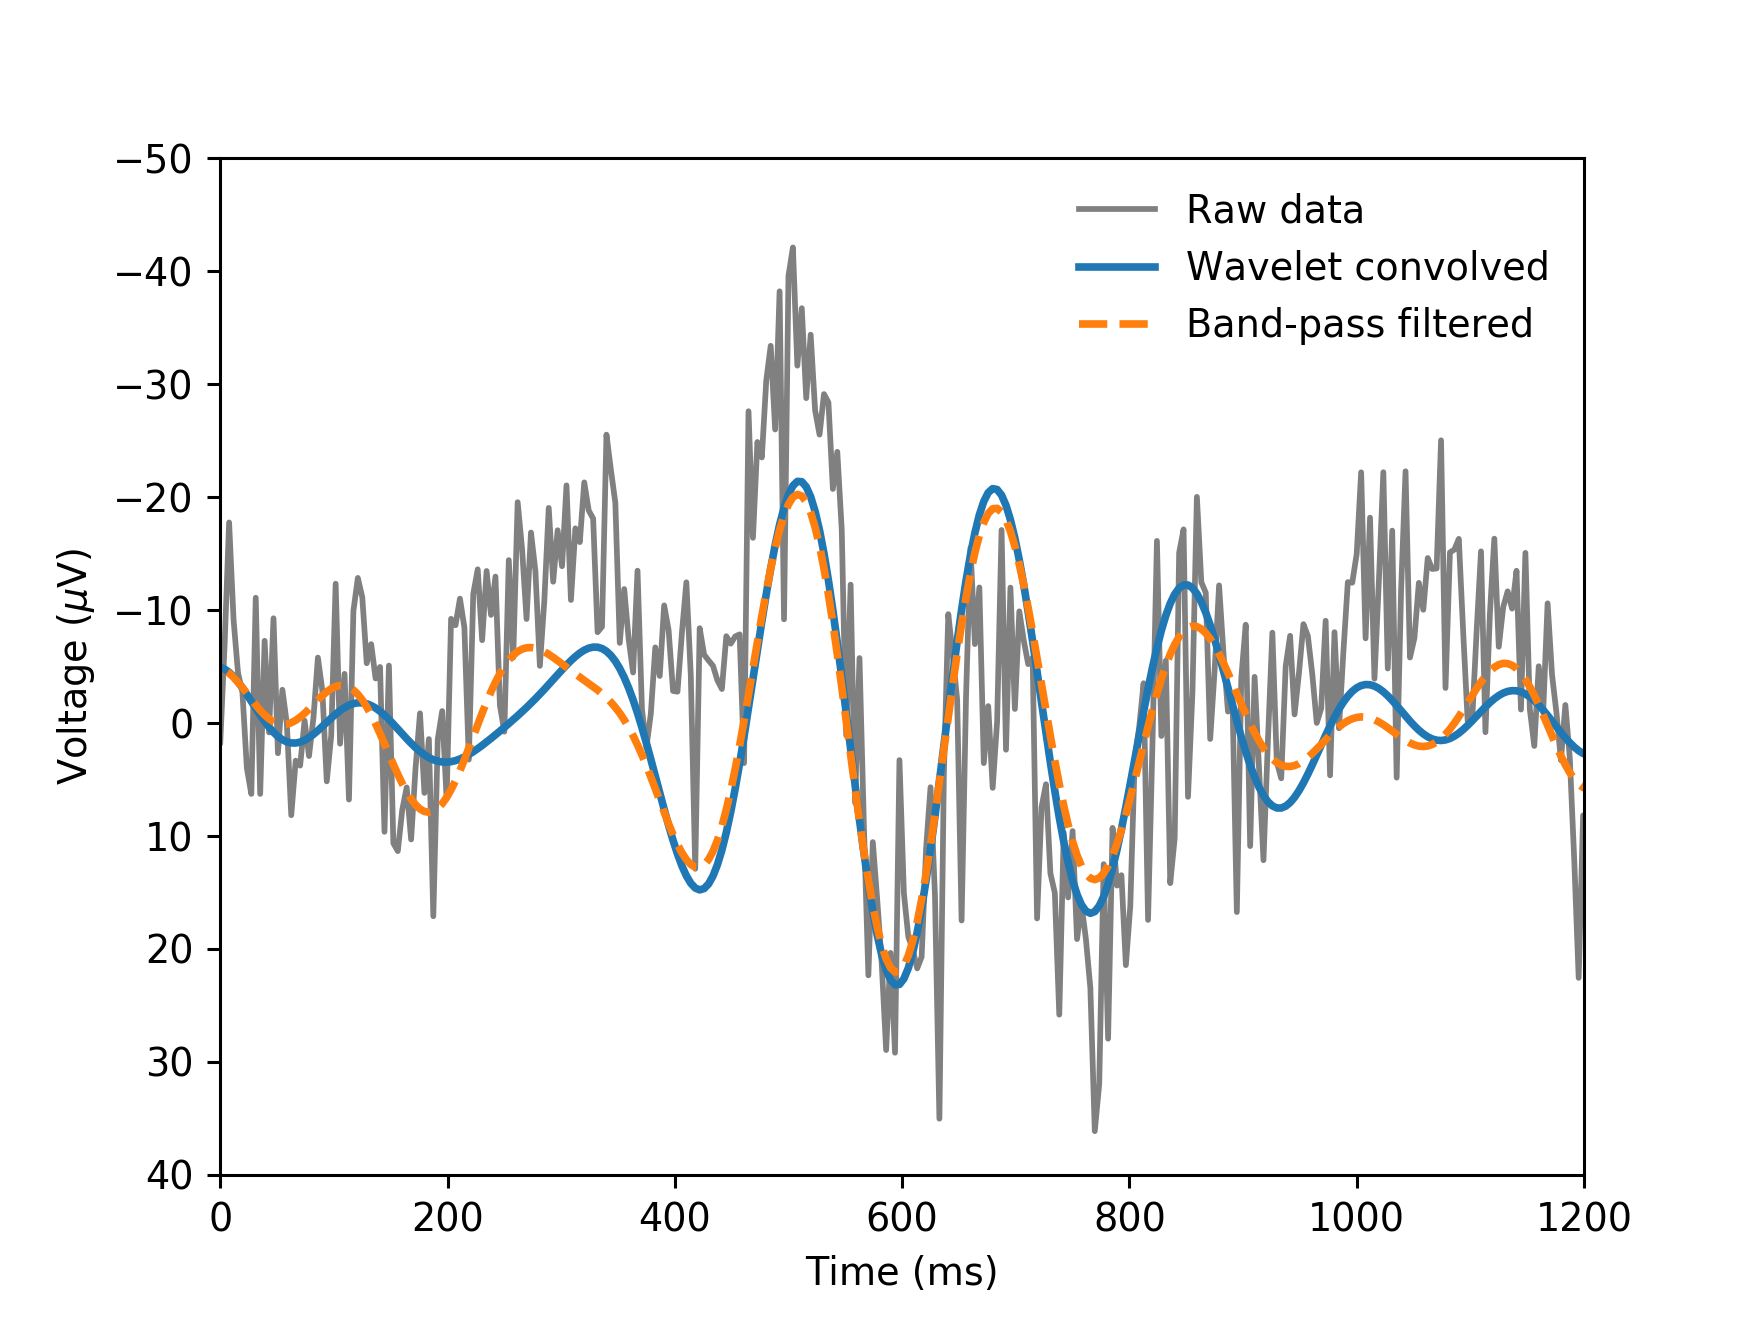

In [6]:
freq = 6
n_cycles = 4.5
eeg_fig5 = np.squeeze(eeg_data[46, :, 9])
time = time_series(samp_rate, end_time=1.496)
time_ms = time*1000

sine_wave = get_sine_wave(freq, samp_rate, complex_wave=True)
gaussian_window = gauss_win(freq, samp_rate, n_cycles)
wavelet = sine_wave * gaussian_window
half_wavelet_idx = ceil(len(wavelet) / 2) - 1

n_conv = len(wavelet) + np.shape(eeg_data)[1] - 1

# Fourier transform the wavelets and a single trial of EEG data at a single channel
fft_w = np.fft.fft(wavelet, n_conv)
fft_e = np.fft.fft(eeg_fig5, n_conv)

# Invert the Fourier transform then multiply by a scaling factor of the standard deviation of the Gaussian window
scale = np.sqrt(n_cycles / (2 * np.pi * freq)) / 10
ift = np.fft.ifft(fft_e * fft_w, n_conv) * scale
wavelet_conv_data = np.real(ift[half_wavelet_idx:len(ift) - half_wavelet_idx])

# Band pass filter the data
eeg_bp = band_pass_erp(eeg_fig5, filter_low=4, filter_high=8, trans_width=0.2, nyq=samp_rate / 2)

plt.figure()
plt.plot(time_ms, eeg_fig5, color='grey')
plt.plot(time_ms, wavelet_conv_data, linewidth=2)
plt.plot(time_ms, eeg_bp, linewidth=2, linestyle='dashed')
plt.xlim([-.200, 1200])
plt.ylim([-50, 40])
plt.gca().invert_yaxis()
plt.xlabel('Time (ms)')
plt.ylabel('Voltage ($\mu$V)')
plt.legend(loc='upper right', labels=('Raw data', 'Wavelet convolved', 'Band-pass filtered'), frameon=False)
plt.show()

### Figure 12.6

<IPython.core.display.Javascript object>


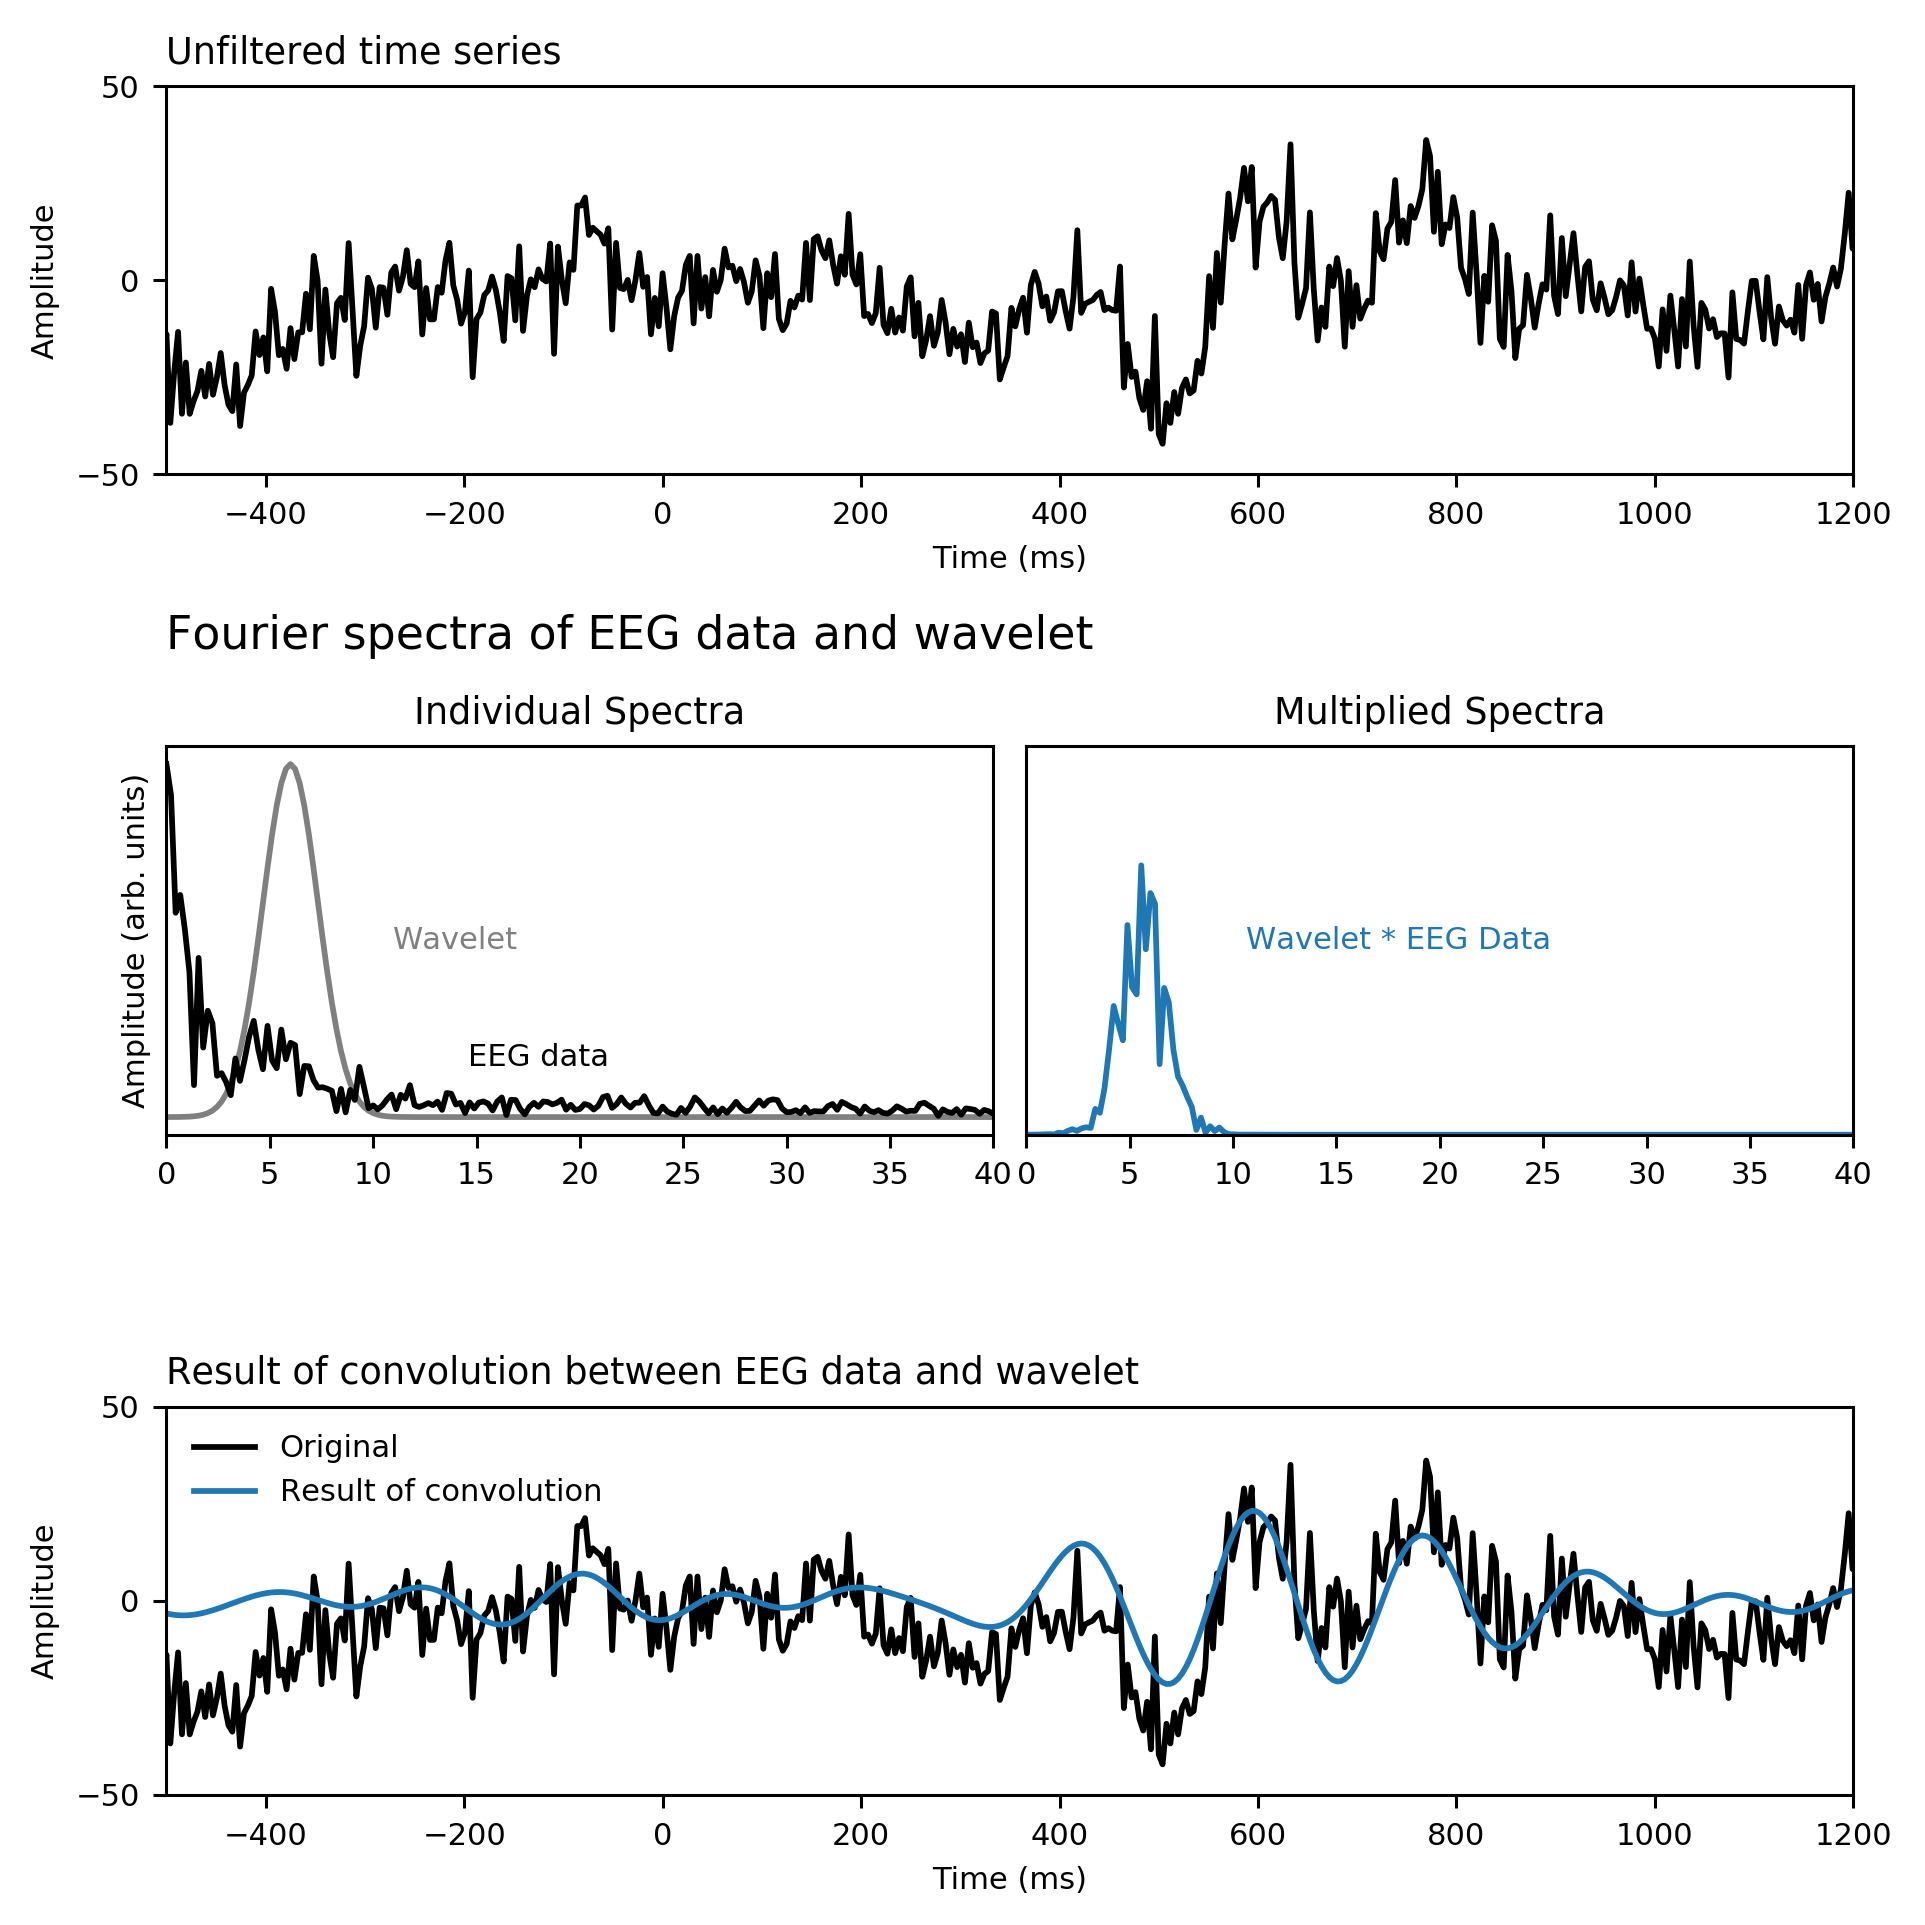

In [7]:
plt.rc('font', size=8)

# Make a theta-band-centered wavelet
n2p1 = int(n_conv / 2) + 1
hz = np.linspace(0, samp_rate / 2, n2p1)

# Set the figure and grid
fig = plt.figure(figsize=(7, 7))
full_grid = fig.add_gridspec(3, 2)

# Set the subgrids
grid_A = full_grid[1, :].subgridspec(1, 2)

ax_A = fig.add_subplot(full_grid[0, :])
ax_A.plot(time_ms, eeg_fig5, color='black')
ax_A.set_xlim([-500, 1200])
ax_A.set_yticks(np.linspace(-50, 50, 3))
ax_A.set_ylim([-50, 50])
ax_A.set_xlabel('Time (ms)')
ax_A.set_ylabel('Amplitude')
ax_A.set_title('Unfiltered time series', loc='left')

ax_B0 = fig.add_subplot(grid_A[0, 0])
ax_B0.plot(hz, np.abs(fft_w[:n2p1]) / np.max(np.abs(fft_w[:n2p1])), color='grey')
ax_B0.plot(hz, np.abs(fft_e[:n2p1]) / np.max(np.abs(fft_e[:n2p1])), color='black')
ax_B0.set_xlim([0, 40])
ax_B0.set_yticks([])
ax_B0.set_ylabel('Amplitude (arb. units)')
ax_B0.text(x=.35, y=.5, s='Wavelet', horizontalalignment='center', 
              verticalalignment='center', transform=ax_B0.transAxes, color='grey')
ax_B0.text(x=.45, y=.2, s='EEG data', horizontalalignment='center', 
              verticalalignment='center', transform=ax_B0.transAxes, color='black')
ax_B0.text(0, 1.25, 'Fourier spectra of EEG data and wavelet', transform=ax_B0.transAxes, fontsize=12)
ax_B0.set_title('Individual Spectra')

ax_B1 = fig.add_subplot(grid_A[0, 1])
ax_B1.plot(hz, np.abs(fft_e[:n2p1]) * np.abs(fft_w[:n2p1]))
ax_B1.set_xlim([0, 40])
ax_B1.set_ylim([0, 1.5e5])
ax_B1.set_yticks([])
ax_B1.text(x=.45, y=.5, s='Wavelet * EEG Data', horizontalalignment='center', 
              verticalalignment='center', transform=ax_B1.transAxes, color='C0')
ax_B1.set_title('Multiplied Spectra')

ax_C = fig.add_subplot(full_grid[2, :])
ax_C.plot(time_ms, eeg_fig5, color='black')
ax_C.plot(time_ms, wavelet_conv_data)
ax_C.set_xlim([-500, 1200])
ax_C.set_yticks(np.linspace(-50, 50, 3))
ax_C.set_ylim([-50, 50])
ax_C.set_xlabel('Time (ms)')
ax_C.set_ylabel('Amplitude')
ax_C.set_title('Result of convolution between EEG data and wavelet', loc='left')
ax_C.legend(labels=('Original', 'Result of convolution'), frameon=False, loc='upper left')

fig.tight_layout()

### Figure 12.7

<IPython.core.display.Javascript object>


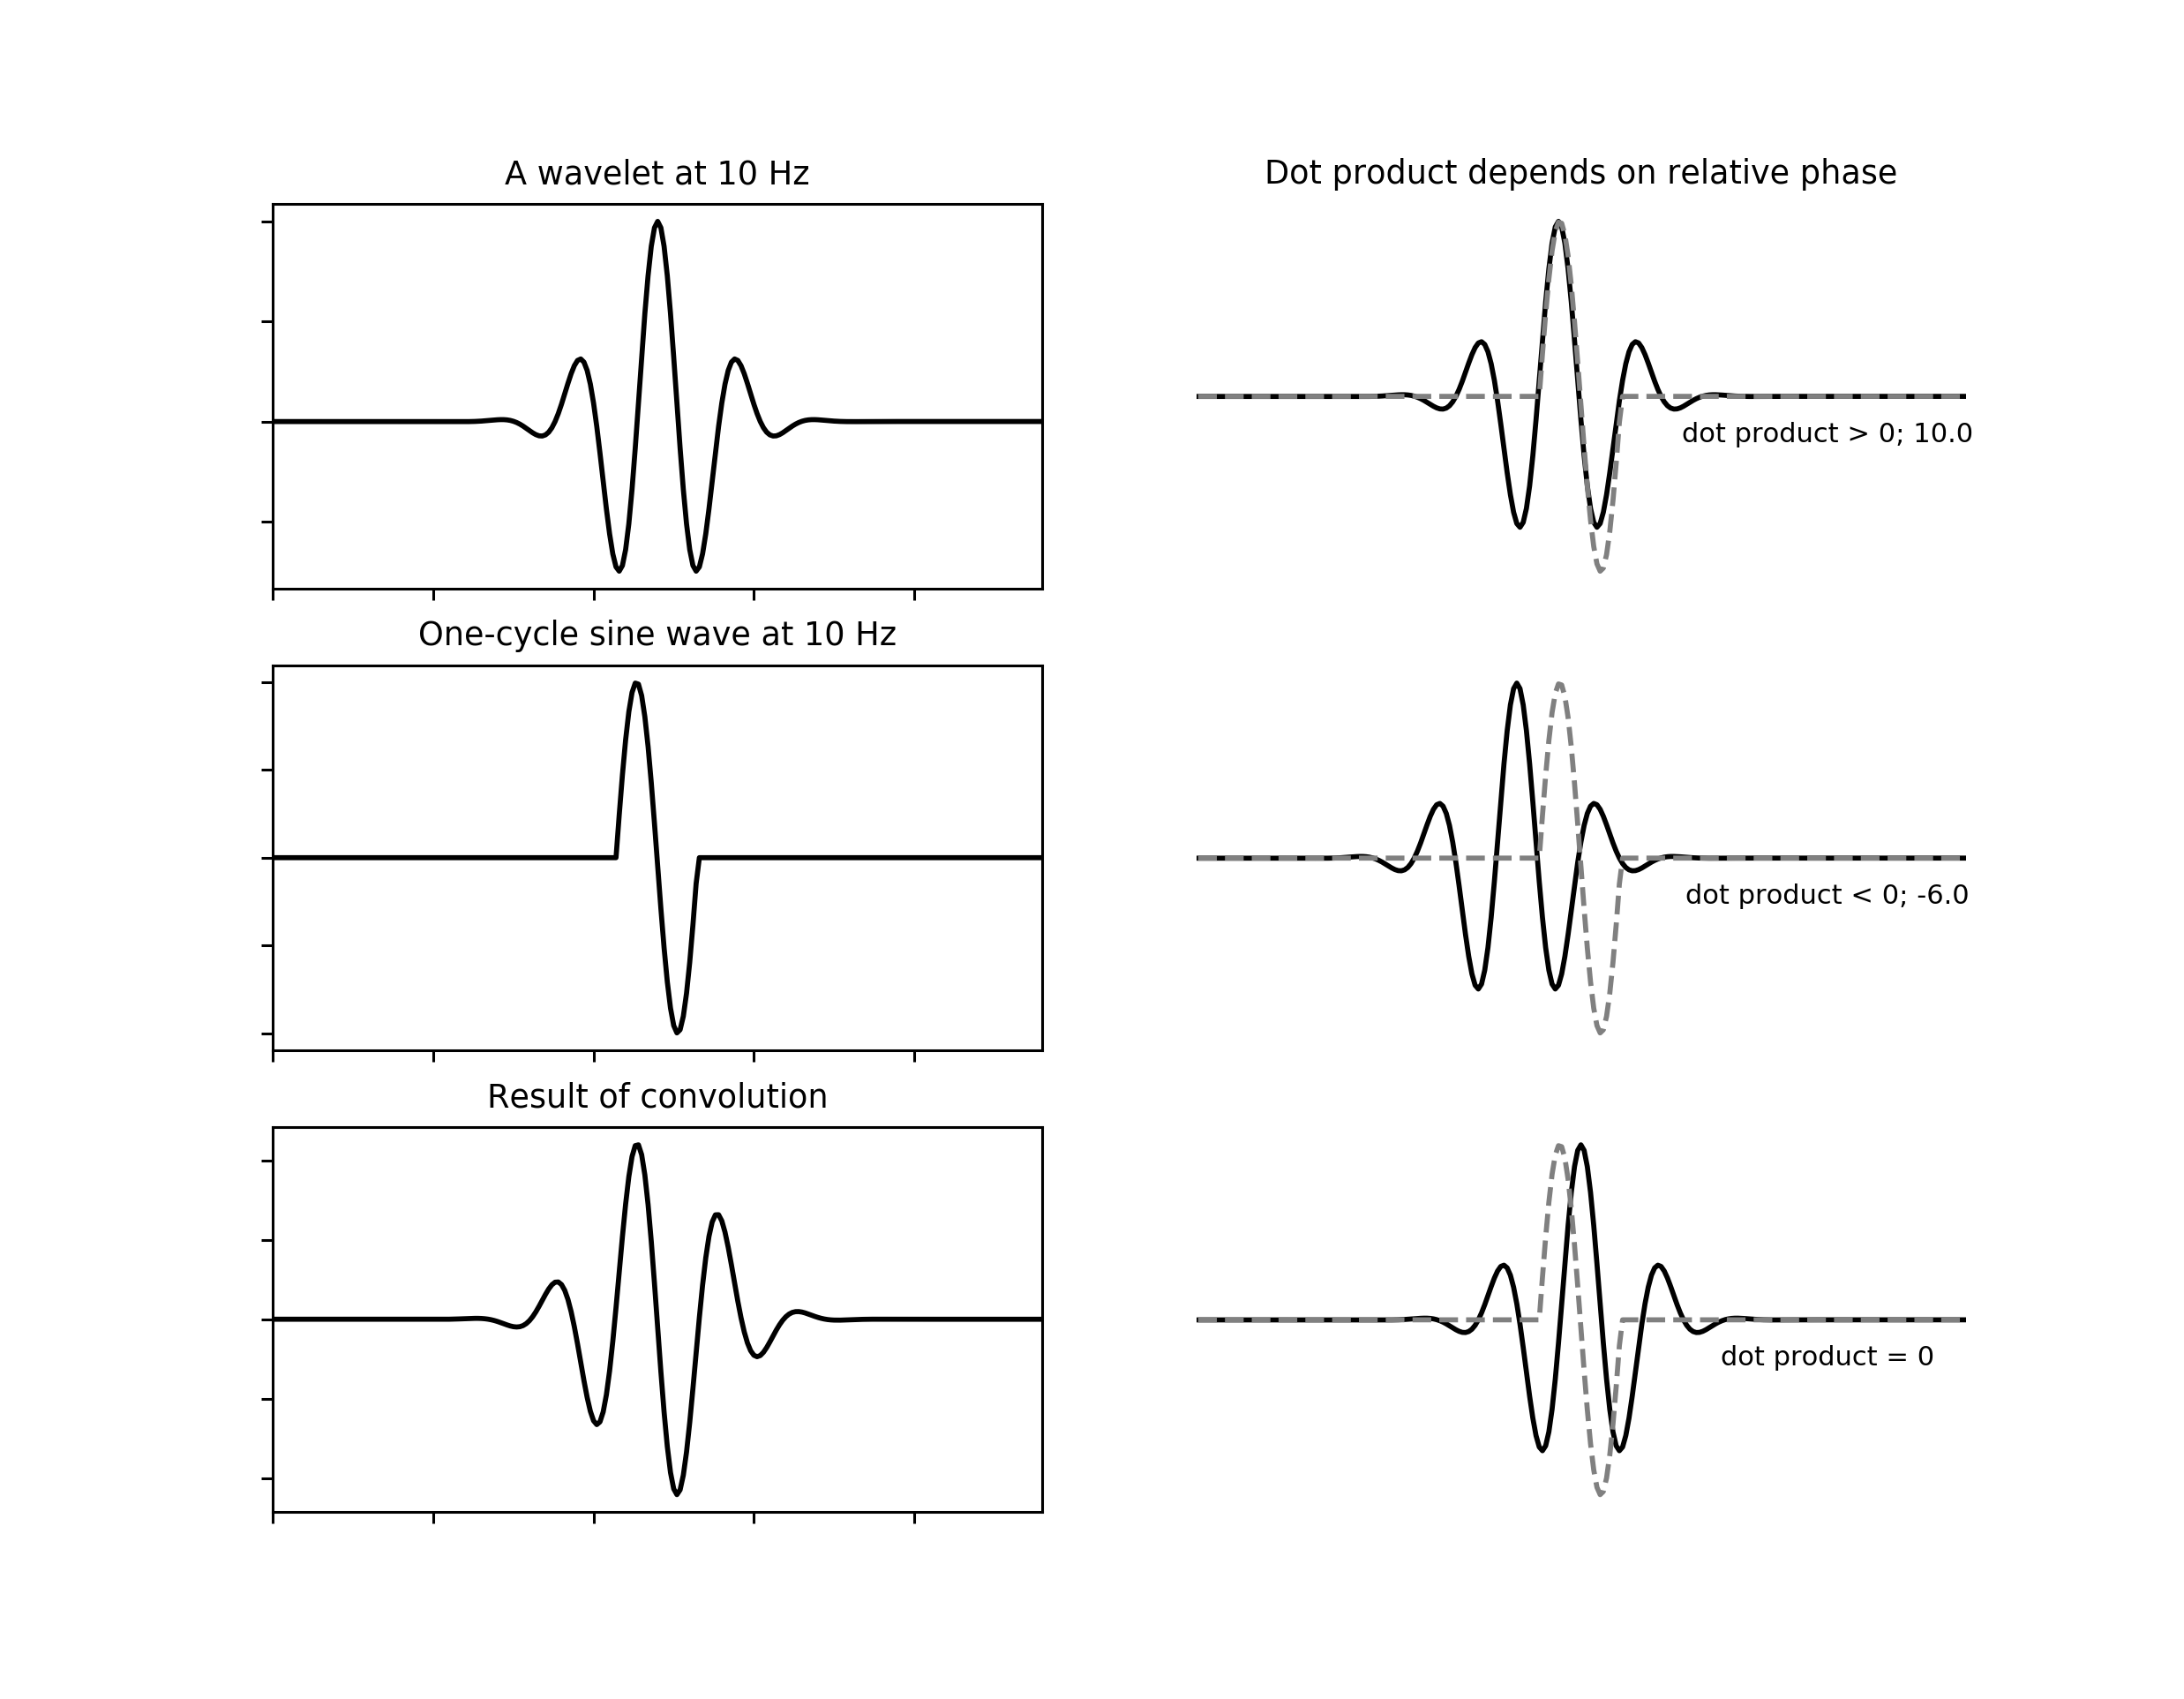

In [8]:
half_time = len(time) / samp_rate / 2
freq = 10
n_cycles = 4

# 10 Hz kernel wavelet
cos_wave = get_sine_wave(freq, samp_rate, start_time=-half_time, end_time=half_time - 1 / samp_rate, cos=True)
gaussian_window = gauss_win(freq, samp_rate, n_cycles, start_time=-half_time, end_time=half_time - 1 / samp_rate)
wavelet = cos_wave * gaussian_window

# Define the cycle as 1/f
signal_no_zp = np.delete(get_sine_wave(freq, samp_rate, start_time=0, end_time=1 / freq), -1)

# Zero-pad the signal to be same length as kernel wavelet
zero_pad = np.zeros(round(len(time) / 2 - len(signal_no_zp) / 2))
signal = np.concatenate((zero_pad, signal_no_zp, zero_pad), axis=None)

# Convolve signal with wavelet (replicates MATLAB's 'same' method)
conv_res = matlab_conv_same(signal, wavelet)

# Get a list of objects to iteratively plot
iter_sig = [wavelet, signal, conv_res]

# Set the figure and grid
fig = plt.figure(figsize=(9, 7))
full_grid = fig.add_gridspec(3, 2)

# Set the subgrids
grid_A = full_grid[:, 0].subgridspec(3, 1)
grid_B = full_grid[:, 1].subgridspec(3, 1)

grid_A_titles = ['A wavelet at 10 Hz', 'One-cycle sine wave at 10 Hz', 'Result of convolution']

# Plot waveforms
for i in range(len(iter_sig)):
    ax_A = fig.add_subplot(grid_A[i, 0])
    ax_A.plot(iter_sig[i], color='black')
    ax_A.set_xlim([200, len(time) - 200])
    ax_A.set_xticklabels([])
    ax_A.set_yticklabels([])
    ax_A.set_title(grid_A_titles[i])
    
# Plot dot products at different phases
wave1 = wavelet[round(100 / freq)-3:]
wave2 = wavelet[round(2.3 * (100 / freq) - 3):]
wave3 = wavelet
iter_wave = [wave1, wave2, wave3]

dot_prod1 = np.fix(np.dot(wavelet[round(100 / freq)-3:], 
                          signal[:-round(100 / freq) + 3]))
dot_prod2 = np.fix(np.dot(wavelet[round(2.3 * (100 / freq) - 3):],
                          signal[:-round(2.3 * (100 / freq) - 3)]))
dot_prod3 = int(np.fix(np.dot(wavelet, signal)))
dot_prods = [' > 0; ', ' < 0; ', ' = ']

for i in range(len(iter_wave)):
    ax_B = fig.add_subplot(grid_B[i, 0])
    ax_B.plot(iter_wave[i], color='black')
    ax_B.plot(signal, color='grey', linestyle='dashed')
    ax_B.set_xlim([200, len(time) - 200])
    ax_B.axis('off')
    ax_B.text(x=.82, y=.4, s='dot product' + dot_prods[i] + str(eval('dot_prod' + str(i + 1))), 
              horizontalalignment='center', verticalalignment='center', transform=ax_B.transAxes, color='black')
    if i == 0:
        ax_B.set_title('Dot product depends on relative phase')